<h1>Cat to English TRANSLATION</h1>

In [1]:
from distutils.version import LooseVersion
import tensorflow as tf
from tensorflow.python.layers.core import Dense


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
!python3.6 -m pip install tensorflow==1.15

In [2]:
import tensorflow as tf
print(tf.__version__)
dir(tf.contrib.rnn)

1.15.0
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



['AttentionCellWrapper',
 'BasicLSTMCell',
 'BasicRNNCell',
 'BidirectionalGridLSTMCell',
 'CompiledWrapper',
 'Conv1DLSTMCell',
 'Conv2DLSTMCell',
 'Conv3DLSTMCell',
 'ConvLSTMCell',
 'CoupledInputForgetGateLSTMCell',
 'DeviceWrapper',
 'DropoutWrapper',
 'EmbeddingWrapper',
 'FusedRNNCell',
 'FusedRNNCellAdaptor',
 'GLSTMCell',
 'GRUBlockCell',
 'GRUBlockCellV2',
 'GRUCell',
 'GridLSTMCell',
 'HighwayWrapper',
 'IndRNNCell',
 'IndyGRUCell',
 'IndyLSTMCell',
 'InputProjectionWrapper',
 'IntersectionRNNCell',
 'LSTMBlockCell',
 'LSTMBlockFusedCell',
 'LSTMBlockWrapper',
 'LSTMCell',
 'LSTMStateTuple',
 'LayerNormBasicLSTMCell',
 'LayerRNNCell',
 'MultiRNNCell',
 'NASCell',
 'OutputProjectionWrapper',
 'PhasedLSTMCell',
 'RNNCell',
 'ResidualWrapper',
 'SRUCell',
 'TimeFreqLSTMCell',
 'TimeReversedFusedRNN',
 'UGRNNCell',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'best_effort_input_batch_size',
 'stack

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import gzip
import codecs
import re
import time
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
from tensorflow.python.layers.core import Dense
from tensorflow.contrib.rnn import GRUCell, DropoutWrapper
from tensorflow.contrib.seq2seq import TrainingHelper, GreedyEmbeddingHelper,BasicDecoder, dynamic_decode, \
 BahdanauAttention, AttentionWrapper,sequence_loss
import helper
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import os
import io


TOKEN_GO = '<GO>'
TOKEN_EOS = '<EOS>'
TOKEN_PAD = '<PAD>'
TOKEN_UNK = '<UNK>'

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from numpy import linalg as LA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
import os
! rm /content/gdrive/My\ Drive/events.out*
os.listdir('/content/gdrive/My Drive')

['02_example.ipynb',
 'data-protfolio.ppt',
 'amazon-fine-food-reviews.zip',
 'attention.py',
 'cat-eng.zip',
 'news.txt.gz',
 'summary.txt.gz',
 'deu-eng.zip',
 'cc.ca.300.vec.gz',
 'Colab Notebooks',
 'data_new.csv',
 'cc.en.300.vec.gz',
 'cc.en.300.bin.gz',
 'cc.ca.300.bin.gz',
 'best_so_far_model.ckpt.index',
 'checkpoint',
 'best_so_far_model.ckpt.data-00000-of-00001',
 'best_so_far_model.ckpt.meta']

In [0]:
if 'cat.txt' not in os.listdir('/content/'):
    !unzip /content/gdrive/My\ Drive/cat-eng.zip
    

In [0]:
path_to_file='/content/cat.txt'

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.rstrip().strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<GO> ' + w + ' <EOS>'
  return w

In [10]:
en_sentence = u"May I borrow this book?"
cat_sentence = u"¿Podrà prendre prestat aquest llibre?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(cat_sentence).encode('utf-8'))

<GO> may i borrow this book ? <EOS>
b'<GO> \xc2\xbf podra prendre prestat aquest llibre ? <EOS>'


In [0]:
num_examples=100000

In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, CATALAN]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  linep=[w  for l in lines for w in l.split('\t') if w.split()[0] != 'CC-BY']
  words = [preprocess_sentence(w) for l in linep[:num_examples] for w in l.split('\t')]
  word_pairs=list(np.array(words).reshape(len(words)//2,2))
  return zip(*word_pairs)

In [13]:
en, cat = create_dataset(path_to_file, None)
print(en[-1])
print(cat[-1])

<GO> we re gonna make sure that no one is taking advantage of the american people for their own short term gain . <EOS>
<GO> ens assegurarem que ningu s estiga aprofitant del poble america per al seu propi interes a curt termini . <EOS>


In [0]:
data=[]
for eng,cata in zip(en,cat):
  data.append([eng,cata])
news=pd.DataFrame(data,columns=['eng','cat'])

In [15]:
news=news.rename(columns={'eng':'Text','cat':'Summary'})
news['Text_len'] = news.Text.apply(lambda x: len(x.split()))
news['Summary_len'] = news.Summary.apply(lambda x: len(x.split()))
news.head()

,Text,Summary,Text_len,Summary_len
0,<GO> wow ! <EOS>,<GO> carai ! <EOS>,4,4
1,<GO> really ? <EOS>,<GO> de veritat ? <EOS>,4,5
2,<GO> thanks . <EOS>,<GO> gracies ! <EOS>,4,4
3,<GO> goodbye ! <EOS>,<GO> adeu ! <EOS>,4,4
4,<GO> hurry up . <EOS>,<GO> afanya t . <EOS>,5,5


In [16]:
print(news['Text'].head(5).values)
print(news['Summary'].head(5).values)

['<GO> wow ! <EOS>' '<GO> really ? <EOS>' '<GO> thanks . <EOS>'
 '<GO> goodbye ! <EOS>' '<GO> hurry up . <EOS>']
['<GO> carai ! <EOS>' '<GO> de veritat ? <EOS>' '<GO> gracies ! <EOS>'
 '<GO> adeu ! <EOS>' '<GO> afanya t . <EOS>']


In [0]:
news_summaries = []
for summary in news.Summary:
    news_summaries.append(summary)
news_texts = []
for text in news.Text:
    news_texts.append(text)

In [18]:
[len(news_summaries), len(news_texts)]

[653, 653]

In [0]:
def count_words(words_dict, text):
    for sentence in text:
        for word in sentence.split():
            if word not in words_dict:
                words_dict[word] = 1
            else:
                words_dict[word] += 1

In [20]:
word_counts_dictx={}
count_words(word_counts_dictx, news_texts)           
print("Total words in eng Vocabulary:", len(word_counts_dictx))

Total words in eng Vocabulary: 991


In [21]:
word_counts_dict = {}
count_words(word_counts_dict, news_summaries)            
print("Total words in cat Vocabulary:", len(word_counts_dict))

Total words in cat Vocabulary: 1166


In [0]:
if 'cc.ca.300.vec' not in os.listdir('/content/'):
  !cp /content/gdrive/My\ Drive/cc.ca.300.vec.gz /content/
  !gunzip /content/cc.ca.300.vec.gz

In [0]:
if 'cc.en.300.vec' not in os.listdir('/content/'):
  !cp /content/gdrive/My\ Drive/cc.en.300.vec.gz /content/
  !gunzip /content/cc.en.300.vec.gz


In [0]:
def build_word_vector_matrix(vector_file):
    embedding_index = {}
    with codecs.open(vector_file, 'r', 'utf-8') as f:
        for i, line in enumerate(f):
            sr = line.split()
            if(len(sr)<26):
                continue
            word = sr[0]
            embedding = np.asarray(sr[1:], dtype='float32')
            embedding_index[word] = embedding
    return embedding_index

                    

In [0]:
# Replace the path here to point to the faster vectors file on your system
embeddings_index = build_word_vector_matrix('/content/cc.ca.300.vec')
embeddings_indexx = build_word_vector_matrix('/content/cc.en.300.vec')
                    

In [26]:
os.listdir('/content')

['.config',
 'gdrive',
 '_about.txt',
 'cc.en.300.vec',
 'cc.ca.300.vec',
 'cat.txt',
 'sample_data']

In [0]:
count_threshold = 20
#special_codes = [TOKEN_UNK,TOKEN_PAD,TOKEN_EOS,TOKEN_GO] 
special_codes =  [TOKEN_UNK,TOKEN_PAD] 

In [0]:
def map_word_int(count_treshold,word_counts_dict,embeddings_index):
          word2int = {} 
          value = 0
          for word, count in word_counts_dict.items():
                     if count >= count_threshold or word in embeddings_index:
                          word2int[word] = value
                          value +=1  

          for code in special_codes:
              word2int[code]=len(word2int)
          int2word = {}
          for word, value in word2int.items():
                int2word[value] = word
          return word2int,int2word

In [0]:
word2intx,int2wordx=map_word_int(20,word_counts_dictx,embeddings_indexx)

In [30]:
[len(word2intx), len(int2wordx)]

[993, 993]

In [0]:
word2int,int2word=map_word_int(20,word_counts_dict,embeddings_index)

In [32]:
[len(word2int),len(int2word)]

[1151, 1151]

In [0]:
embedding_dim = 300

def word_embeddings_matrix(embedding_dim, word2int,embeddings_index):
        nwords = len(word2int)
        word_emb_matrix = np.zeros((nwords, embedding_dim), dtype=np.float32)
        for word, i in word2int.items():
                  if word in embeddings_index:
                          word_emb_matrix[i] = embeddings_index[word]
                  else:
                          new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
                          word_emb_matrix[i] = new_embedding
        return word_emb_matrix

In [0]:
word_emb_matrixx=word_embeddings_matrix(300,word2intx,embeddings_indexx)

In [35]:
print("Length of word embeddings on eng: ", len(word_emb_matrixx))

Length of word embeddings on eng:  993


In [0]:
word_emb_matrix=word_embeddings_matrix(300,word2int,embeddings_index)

In [37]:
print("Length of word embeddings on cat: ", len(word_emb_matrix))

Length of word embeddings on cat:  1151


In [0]:
def convert_sentence_to_ids(text,word2int, eos=False):
    wordints = []
    word_count = 0
    for sentence in text:
        sentence2ints = []
        for word in sentence.split():
            word_count += 1
            if word in word2int:
                sentence2ints.append(word2int[word])
            else:
                sentence2ints.append(word2int[TOKEN_UNK])
        if eos:
            sentence2ints.append(word2int[TOKEN_EOS])
        wordints.append(sentence2ints)
    return wordints, word_count

In [0]:
id_summaries, word_count = convert_sentence_to_ids(news_summaries,word2int)
id_texts, word_countx = convert_sentence_to_ids(news_texts,word2intx,eos=True)

In [40]:
[[len(id_summaries),word_count],[len(id_texts),word_countx]]

[[653, 6076], [653, 6258]]

In [0]:
def unknown_tokens(sentence,word2int):
    unk_token_count = 0
    for word in sentence:
        if word == word2int[TOKEN_UNK]:
            unk_token_count += 1
    return unk_token_count

In [0]:
news_summaries_filtered = []
news_texts_filtered = []
max_text_length = int(news.Text_len.mean() + news.Text_len.std())
max_summary_length = int(int(news.Summary_len.mean() + news.Summary_len.std()))
min_length = 4
unknown_token_text_limit = 10
unknown_token_summary_limit = 4

for count,text in enumerate(id_texts):
    unknown_token_text = unknown_tokens(id_texts[count],word2intx)
    unknown_token_summary = unknown_tokens(id_summaries[count],word2int)
    text_len = len(id_texts[count])
    summary_len = len(id_summaries[count])
    if((unknown_token_text>unknown_token_text_limit) or (unknown_token_summary>unknown_token_summary_limit)):
        continue
    if(text_len<min_length or summary_len<min_length or text_len>max_text_length or summary_len>max_summary_length):
        continue
    news_summaries_filtered.append(id_summaries[count])
    news_texts_filtered.append(id_texts[count])


In [43]:
[len(news_summaries_filtered),len(news_texts_filtered)]

[514, 514]

In [0]:
def convert(lang,int2word, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, int2word[t]))

In [45]:
print ("Input Language; index to word mapping")
convert(news_texts,int2wordx, news_texts_filtered[5])
print ()
print ("Target Language; index to word mapping")
convert(news_summaries, int2word, news_summaries_filtered[5])

Input Language; index to word mapping
11 ----> too
12 ----> late
7 ----> .
3 ----> <EOS>
3 ----> <EOS>

Target Language; index to word mapping
12 ----> massa
13 ----> tard
11 ----> .
3 ----> <EOS>


In [0]:
def model_inputs():
    inputs_data = tf.placeholder(tf.int32, [None, None], name='input_data')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    dropout_probs = tf.placeholder(tf.float32, name='dropout_probs')
    summary_len = tf.placeholder(tf.int32, (None,), name='summary_len')
    max_summary_len = tf.reduce_max(summary_len, name='max_summary_len')
    text_len = tf.placeholder(tf.int32, (None,), name='text_len')
    return inputs_data, targets, learning_rate, dropout_probs, summary_len, max_summary_len, text_len

In [0]:
def process_decoding_input(target_data, word2int, batch_size):
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    decoding_input = tf.concat([tf.fill([batch_size, 1], word2int[TOKEN_GO]), ending], 1)
    return decoding_input

In [0]:
def get_cell(csize,dprob):
    rnc = GRUCell(csize)
    rnc = DropoutWrapper(rnc, input_keep_prob = dprob)
    return rnc

def encoding_layer(csize, len_s, nl, rinp, dprob):
    for l in range(nl):
        with tf.variable_scope('encoding_l_{}'.format(l)):
            rnn_frnt = get_cell(csize,dprob)
            rnn_bkwd = get_cell(csize,dprob)
            eop, est = tf.nn.bidirectional_dynamic_rnn(rnn_frnt, rnn_bkwd, 
                                                                    rinp,
                                                                    len_s,
                                                                    dtype=tf.float32)
    eop = tf.concat(eop,nl)
    return eop, est

In [0]:
def trng_dec_layer(dec_emb_inp, summ_len, cell_dec, st_init, lyr_op, 
                            v_size, max_summ_len):
    helper = TrainingHelper(inputs=dec_emb_inp,sequence_length=summ_len, time_major=False)
    dec = BasicDecoder(cell_dec,helper,st_init,lyr_op) 
    logits, _, _ = dynamic_decode(dec,output_time_major=False,impute_finished=True, 
                                  maximum_iterations=max_summ_len)
    return logits

In [0]:
def infr_dec_layer(embeddings, start_token, end_token, decoding_cell, initial_state, op_layer,
                             max_summary_len, batch_size):
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    inf_helper = GreedyEmbeddingHelper(embeddings,start_tokens,end_token)
    inf_decoder = BasicDecoder(decoding_cell,inf_helper,initial_state,op_layer)       
    inf_logits, _, _ = dynamic_decode(inf_decoder,output_time_major=False,impute_finished=True,
                                                            maximum_iterations=max_summary_len)
    return inf_logits

In [0]:
def decoding_layer(dec_emb_op, embs, enc_op, enc_st, v_size, txt_len, 
                   summ_len,mx_summ_len, rnsize, word2int, dprob, batch_size, nlyrs):
    
    for l in range(nlyrs):
        with tf.variable_scope('dec_rnn_layer_{}'.format(l)):
            gru = tf.contrib.rnn.GRUCell(rnn_len)
            cell_dec = tf.contrib.rnn.DropoutWrapper(gru,input_keep_prob = dprob)
            
    out_l = Dense(v_size, kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    attention = BahdanauAttention(rnsize, enc_op,txt_len,
                                                  normalize=False,
                                                  name='BahdanauAttention')
    cell_dec =  AttentionWrapper(cell_dec,attention,rnn_len)
    attn_zstate = cell_dec.zero_state(batch_size , tf.float32 )
    attn_zstate = attn_zstate.clone(cell_state = enc_st[0])
    with tf.variable_scope("decoding_layer"):
        tr_dec_op = trng_dec_layer(dec_emb_op, 
                                                  summ_len, 
                                                  cell_dec, 
                                                  attn_zstate,
                                                  out_l,
                                                  v_size, 
                                                  mx_summ_len)
    with tf.variable_scope("decoding_layer", reuse=True):
        inf_dec_op = infr_dec_layer(embs,  
                                                    word2int[TOKEN_GO], 
                                                    word2int[TOKEN_EOS],
                                                    cell_dec, 
                                                    attn_zstate, 
                                                    out_l,
                                                    mx_summ_len,
                                                    batch_size)

    return tr_dec_op, inf_dec_op

In [0]:
def seq2seq_model(data_inp, data_summ_tgt, dprob, len_txt, len_summ, max_len_summ, 
                  v_size, rnsize, nlyrs, word2int, batch_size):
    
    inp_embx = word_emb_matrixx # modification 
    word_embs = tf.Variable(inp_embx, name="word_embs") # modification
    inp_enc_emb = tf.nn.embedding_lookup(word_embs, data_inp)
    op_enc, st_enc = encoding_layer(rnsize, len_txt, nlyrs, inp_enc_emb, dprob)
    
    inp_dec = process_decoding_input(data_summ_tgt, word2int, batch_size)
    inp_emb = word_emb_matrix # modification 
    inp_dec_emb = tf.nn.embedding_lookup(inp_emb, inp_dec)
    
    op_tr, op_inf  = decoding_layer(inp_dec_emb, 
                                                        inp_emb,
                                                        op_enc,
                                                        st_enc, 
                                                        v_size, 
                                                        len_txt, 
                                                        len_summ, 
                                                        max_len_summ,
                                                        rnsize, 
                                                        word2int, 
                                                        dprob, 
                                                        batch_size,
                                                        nlyrs)
    
    return op_tr, op_inf

In [0]:
def pad_sentences(sentences_batch,word2int):

    max_sentence = max([len(sentence) for sentence in sentences_batch])
    return [sentence + [word2int[TOKEN_PAD]] * (max_sentence - len(sentence)) for sentence in sentences_batch]

In [0]:
def get_batches(summaries, texts, batch_size):

    for batch_idx in range(0, len(texts)//batch_size):

        start_idx = batch_idx * batch_size

        summaries_batch = summaries[start_idx:start_idx + batch_size]
        texts_batch = texts[start_idx:start_idx + batch_size]

        pad_summaries_batch = np.array(pad_sentences(summaries_batch,word2int))
        pad_texts_batch = np.array(pad_sentences(texts_batch,word2intx))

        pad_summaries_lens = []
        for summary in pad_summaries_batch:
            pad_summaries_lens.append(len(summary))
        
        pad_texts_lens = []
        for text in pad_texts_batch:
            pad_texts_lens.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lens, pad_texts_lens

In [0]:
def train_on_batch(session, X, X_seq_len, Y, Y_seq_len, learning_rate, dropout_keep_probability):
    feed_dict = {
            data_inp: X,
            tgts:Y,
            lrt:learning_rate,
            len_summ:Y_seq_len,
            len_txt: X_seq_len,
            dprobs: dropout_keep_probability}

    _,pred,loss,summary = session.run([
            train_op,
            tr_cost,
            inf_op,
            merged_summary_op], feed_dict=feed_dict)
    return _,pred, loss, summary

In [0]:
def predict_for_batch(session, X, X_seq_len,Y, Y_seq_len,dropout_keep_probability):

    feed_dict={data_inp:X, len_txt:X_seq_len,tgts:Y, len_summ: Y_seq_len,dprobs: dropout_keep_probability}

    pred = session.run([inf_op], feed_dict=feed_dict)[0]

    return pred


In [0]:

def predict_for_batch_with_loss(session, X, X_seq_len, Y, Y_seq_len,learning_rate,dropout_keep_probability):
    
    feed_dict={data_inp:X, len_txt:X_seq_len, tgts:Y, len_summ: Y_seq_len,lrt:learning_rate,dprobs: dropout_keep_probability}
    
    _,loss,pred = session.run([train_op,tr_cost,infer_predictions], feed_dict=feed_dict)
    
    return pred, loss

In [0]:
batch_size =32
rnn_len = 256
n_layers = 1
lr = 0.0025
dr_prob =0.75
logs_path='/content/gdrive/My Drive/'

In [59]:
train_graph = tf.Graph()
with train_graph.as_default():
    
    data_inp, tgts, lrt, dprobs, len_summ, max_len_summ, len_txt = model_inputs()

    tr_opp, inf_opp = seq2seq_model(tf.reverse(data_inp, [-1]),
                                                      tgts, 
                                                      dprobs,   
                                                      len_txt,
                                                      len_summ,
                                                      max_len_summ,
                                                      len(word2int)+1,
                                                      rnn_len, 
                                                      n_layers, 
                                                      word2int,
                                                      batch_size)
    
    tr_op = tf.identity(tr_opp.rnn_output, 'tr_op')
    inf_op = tf.identity(inf_opp.sample_id, name='predictions')
    
    seq_masks = tf.sequence_mask(len_summ, max_len_summ, dtype=tf.float32, name='masks')

    with tf.name_scope("optimizer"):
        tr_cost = sequence_loss(tr_op,tgts,seq_masks)
        optzr = tf.train.AdamOptimizer(lrt)
        grds = optzr.compute_gradients(tr_cost)
        capped_grds = [(tf.clip_by_value(grd, -5., 5.), var) for grd, var in grds 
                        if grd is not None]
        train_op = optzr.apply_gradients(capped_grds)
    # Get predictions for evaluation.
    train_predictions = tr_opp.sample_id
    infer_predictions = inf_opp.sample_id
    tf.summary.scalar("cost", tr_cost)
print("Graph created.")

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Graph created.


In [0]:
def text_to_seq(text):
    return [word2int.get(word, word2int[TOKEN_UNK]) for word in text.split()]

In [0]:
# Program to measure similarity between  
# two sentences using cosine similarity. 
def mean_absolute_error_texts(v1,v2):
    meanerrorl2=[]
    for X,Y in zip(v1,v2):
        # tokenization 
        X_list = word_tokenize(X)  
        Y_list = word_tokenize(Y) 
  
        # sw contains the list of stopwords 
        sw = stopwords.words('english')  
        l1 =[];l2 =[] 
  
        # remove stop words from string 
        X_set = {w for w in X if not w in sw}  
        Y_set = {w for w in Y if not w in sw} 
  
        # form a set containing keywords of both strings  
        rvector = X_set.union(Y_set)  
        for w in rvector: 
            if w in X_set:
               l1.append(1) # create a vector 
            else:
               l1.append(0) 
            if w in Y_set:
               l2.append(1) 
            else:
               l2.append(0) 
        c = 0
        # cosine formula  
        for i in range(len(rvector)): 
                      c+= l1[i]*l2[i] 
        den=float((sum(l1)*sum(l2))**0.5)
        try: 
           cosine = c /den
        except:
           cosine=0.0 
        meanerrorl2.append(cosine) 
        #return LA.norm(meanerrorl2,2)*100.0,
    return np.mean(meanerrorl2)*100

In [0]:
epochs =50
min_learning_rate = 0.0006
display_step = 50
early_stop_cnt = 0 
early_stop_cnt_max = 3 
per_epoch = 3 


update_loss = 0 
batch_loss = 0
summary_update_loss = [] 

news_summaries_train = news_summaries_filtered[0:410]
news_texts_train = news_texts_filtered[0:410]

news_summaries_test =news_summaries_filtered[410:]
news_texts_test=news_texts_filtered[410:]

goo = word2int[TOKEN_GO]
pad = word2int[TOKEN_PAD] 
eos = word2int[TOKEN_EOS]  
unk = word2int[TOKEN_UNK]
tokens_id=[eos,pad,unk,goo]

update_check = (len(news_texts_train)//batch_size//per_epoch)-1
checkpoint = logs_path + 'best_so_far_model.ckpt' 


In [63]:
invalid_number_prediction_counts = []
all_model_predictions = []
all_ground_truth = []
history=[]
print('Start training... \n')

with tf.Session(graph=train_graph) as sess:
    tf_summary_writer = tf.summary.FileWriter(logs_path, graph=train_graph)
    merged_summary_op = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    for epoch_i in range(epochs):
        update_loss = 0
        batch_loss = 0
        train_loss =0
        for batch_i, (summaries_batch, texts_batch, summaries_len, texts_len) in enumerate(
                get_batches(news_summaries_train, news_texts_train,batch_size)):
            before = time.time()
            _,loss,predictions,summary=train_on_batch(sess,texts_batch, texts_len, summaries_batch, summaries_len, lr, dr_prob)
          
            batch_loss += loss
            update_loss += loss
            after = time.time()
            batch_time = after - before
            tf_summary_writer.add_summary(summary, epoch_i * batch_size + batch_i)
            
            if batch_i % display_step == 0 and batch_i > 0:
                print('** Epoch {:>3}/{} Batch {:>4}/{} - Batch Loss: {:>6.3f}, seconds: {:>4.2f}'
                      .format(epoch_i+1,
                              epochs, 
                              batch_i, 
                              len(news_texts_filtered) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0
            
            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss:", round(update_loss/update_check,3))
                train_loss=round(update_loss/update_check,3)
                summary_update_loss.append(update_loss)
                
                if update_loss <= min(summary_update_loss):
                    print('Saving model') 
                    early_stop_cnt = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    early_stop_cnt += 1
                    if early_stop_cnt == early_stop_cnt_max:
                        break
                update_loss = 0

        summaries_test_batch, texts_test_batch, summaries_test_len, texts_test_len =\
         next(get_batches(news_summaries_test, news_texts_test,batch_size))
    
        predictions,test_loss = predict_for_batch_with_loss(sess,texts_test_batch, texts_test_len,summaries_test_batch,summaries_test_len,lr,1.0)
        history.append([epoch_i+1,train_loss,test_loss])
        print('history:',history[-1])
        print(" ")  
        print('Test: epoch', epoch_i+1, 'loss:', test_loss,)
        print(" ")
        for text, summary, result_logits  in list(zip(texts_test_batch, summaries_test_batch, predictions))[-3:]: 
                     print('\nText')
                     print('  Word Ids:    {}'.format([i for i in text]))
                     print('  Input Words: {}'.format(" ".join( int2wordx[i] for i in text if i not in tokens_id)))

                     print('\nSummary')
                     print('  Word Ids:       {}'.format([i for i in result_logits if i not in tokens_id]))
                     print('  Response Words: {}'.format(" ".join(int2word[i] for i in result_logits if i not in tokens_id )))
                     print(' Ground Truth: {}'.format(" ".join(int2word[i] for i in summary if i not in tokens_id)))
                     print('')
        model_predictions = []
        ground_truth = []
        invalid_number_prediction_count = 0

        ind=0
        for summaries_test_batch, texts_test_batch, summaries_test_len, texts_test_len\
         in get_batches(news_summaries_test,news_texts_test,batch_size=batch_size):
                 
  
                 #summaries_test_len=[np.random.randint(5,8)]
                 pred=predict_for_batch(sess, texts_test_batch, texts_test_len,summaries_test_batch,summaries_test_len,1.0)   
                 
                 for y,p in list(zip(summaries_test_batch,pred)): 
                     Y=''.join(int2word[i] for i in y if i not in tokens_id)
                     O=''.join(int2word[i] for i in p if i not in tokens_id)
                     
                     if mean_absolute_error_texts([Y],[O])< 5 or len(O)< len(Y): 
                             invalid_number_prediction_count += 1
                     
                     lmin=min(len(Y),len(O))+1
                     OO=O[:lmin]
                     YY=Y[:lmin] 
                     model_predictions.append(O)
                     ground_truth.append(Y)
        all_model_predictions.append(model_predictions)
        all_ground_truth.append(ground_truth)
        invalid_number_prediction_counts.append(invalid_number_prediction_count)
         
        if early_stop_cnt == early_stop_cnt_max:
            print("Stopping Training.")
            break        


Start training... 

Average loss: 7.971
Saving model
Average loss: 4.007
Saving model
Average loss: 4.04
No Improvement.
history: [1, 4.04, 4.130271]
 
Test: epoch 1 loss: 4.130271
 

Text
  Word Ids:    [0, 16, 241, 242, 138, 651, 81, 652, 399, 7, 3, 3]
  Input Words: i d like to meet your older sister .

Summary
  Word Ids:       [82, 82, 132, 11]
  Response Words: no no que .
 Ground Truth: m agradaria coneixer la teva germana gran .


Text
  Word Ids:    [0, 16, 24, 11, 24, 69, 70, 658, 466, 7, 3, 3]
  Input Words: i , too , didn t understand anything .

Summary
  Word Ids:       [82, 82, 82, 11]
  Response Words: no no no .
 Ground Truth: jo tampoc entenc res .


Text
  Word Ids:    [0, 67, 659, 84, 598, 138, 143, 215, 5, 3, 3, 992]
  Input Words: is anybody here willing to do that ? <PAD>

Summary
  Word Ids:       [82, 82, 132, 11]
  Response Words: no no que .
 Ground Truth: algu esta disposat a fer allo ?

Average loss: 4.341
No Improvement.
Average loss: 3.034
Saving model
Av

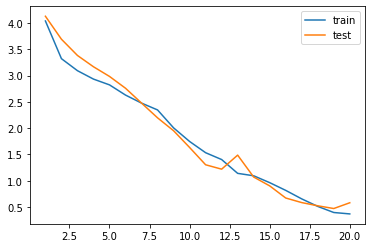

In [64]:
history=pd.DataFrame(history, columns=['epochs','loss','val_loss'])
from matplotlib import pyplot 
pyplot.plot(history['epochs'],history['loss'], label='train') 
pyplot.plot(history['epochs'],history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [65]:
history

,epochs,loss,val_loss
0,1,4.040,4.130271
1,2,3.323,3.692981
2,3,3.094,3.383813
3,4,2.934,3.168670
4,5,2.824,2.984884
5,6,2.630,2.759974
6,7,2.477,2.477530
7,8,2.347,2.196713
8,9,2.006,1.951292
9,10,1.747,1.632557


In [0]:
#Evaluate results¶
#Because our task is simple and the output is straight-forward, we will use MAE metric to evaluate the trained model during the epochs. Compute the value of the metric for the output from each epoch.


In [67]:
for i, (gts, predictions, invalid_number_prediction_count) in enumerate(zip(all_ground_truth,
                                                                            all_model_predictions,
                                                                            invalid_number_prediction_counts), 1):
       

          mae=mean_absolute_error_texts(gts, predictions)
          print("Epoch: %i, MAE: %f, Invalid numbers: %i" % (i, mae, invalid_number_prediction_count))

Epoch: 1, MAE: 42.640143, Invalid numbers: 96
Epoch: 2, MAE: 53.935989, Invalid numbers: 95
Epoch: 3, MAE: 53.935989, Invalid numbers: 95
Epoch: 4, MAE: 53.935989, Invalid numbers: 95
Epoch: 5, MAE: 67.419986, Invalid numbers: 95
Epoch: 6, MAE: 60.302269, Invalid numbers: 95
Epoch: 7, MAE: 67.419986, Invalid numbers: 87
Epoch: 8, MAE: 85.280287, Invalid numbers: 89
Epoch: 9, MAE: 79.772404, Invalid numbers: 89
Epoch: 10, MAE: 73.854895, Invalid numbers: 84
Epoch: 11, MAE: 85.280287, Invalid numbers: 74
Epoch: 12, MAE: 81.818182, Invalid numbers: 76
Epoch: 13, MAE: 90.909091, Invalid numbers: 79
Epoch: 14, MAE: 100.000000, Invalid numbers: 81
Epoch: 15, MAE: 100.000000, Invalid numbers: 80
Epoch: 16, MAE: 100.000000, Invalid numbers: 73
Epoch: 17, MAE: 95.346259, Invalid numbers: 78
Epoch: 18, MAE: 100.000000, Invalid numbers: 62
Epoch: 19, MAE: 95.346259, Invalid numbers: 71
Epoch: 20, MAE: 95.346259, Invalid numbers: 62


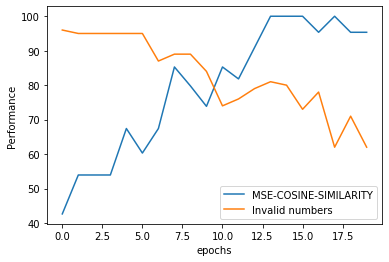

In [3]:
msec={}
msec['MSE-COSINE-SIMILARITY']=[42.640143,53.935989, 53.935989,53.935989, 67.419986, 60.302269,67.419986,85.280287, 
79.772404, 73.854895, 85.280287, 81.818182, 90.909091, 100.000000, 100.000000, 100.000000, 95.346259, 100.000000,
95.346259, 95.346259]
msec['Invalid numbers']=[96,95,95,95,95,95,87,89,89,84,74,76,79,81,80,73,78,62,71,62]
import pandas as pd 
msec=pd.DataFrame.from_dict(msec)
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for name in msec.columns:
    ax.plot(msec[name].values,label=name)

ax.set_xlabel("epochs")
ax.set_ylabel("Performance")
ax.legend(loc='best')

In [70]:

#random = np.random.randint(0,3000)
#text = news_texts_filtered[random]
model_predictions = []
ground_truth = []
invalid_number_prediction_count = []
checkpoint = logs_path + 'best_so_far_model.ckpt' 
print("\n----Prepare evaluation")
for ii in range(99):
    random = np.random.randint(410,513)
    text = news_texts_filtered[random]

    #random = np.random.randint(3000,len(news_texts_filtered))
        
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
                  loader = tf.train.import_meta_graph(checkpoint + '.meta')
                  loader.restore(sess, checkpoint)
                  input_data = loaded_graph.get_tensor_by_name('input_data:0')
                  logits = loaded_graph.get_tensor_by_name('predictions:0')
                  text_length = loaded_graph.get_tensor_by_name('text_len:0')
                  summary_length = loaded_graph.get_tensor_by_name('summary_len:0')
                  keep_prob = loaded_graph.get_tensor_by_name('dropout_probs:0')
                  result_logits = sess.run(logits, {input_data: [text]*batch_size, 
                  summary_length: [np.random.randint(5,8)], 
                  text_length: [len(text)]*batch_size,
                  keep_prob: 1.0})[0] 

    
                  
                  O=" ".join(int2word[i] for i in result_logits if i not in tokens_id)
                  Y=" ".join(int2word[i] for i in news_summaries_filtered[random] if i not in tokens_id)
                  if mean_absolute_error_texts([Y],[O]) >90.00:
                     print('        ')
                     print('        ')
                     #print('\nOriginal Text:', input_sentence)

                     print('\nText')
                     print('  Word Ids:    {}'.format([i for i in text]))
                     print('  Input Words: {}'.format(" ".join( int2wordx[i] for i in text if i not in tokens_id)))

                     print('\nSummary')
                     print('  Word Ids:       {}'.format([i for i in result_logits if i not in tokens_id]))
                     print('  Response Words: {}'.format(" ".join(int2word[i] for i in result_logits if i not in tokens_id)))
                     print(' Ground Truth: {}'.format(" ".join(int2word[i] for i in news_summaries_filtered[random] if i not in tokens_id)))
                     print('        ')
                     print('        ')
 
model_predictions.append(result_logits)
ground_truth.append(news_summaries_filtered[random])         
print('\n...prepare evaluation finished.')


----Prepare evaluation
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
        
        

Text
  Word Ids:    [0, 305, 47, 81, 618, 213, 73, 619, 7, 3, 3]
  Input Words: tell me your plans for the future .

Summary
  Word Ids:       [692, 56, 123, 693, 694, 149]
  Response Words: explica m els teus plans per
 Ground Truth: ex

In [69]:
print("Finish ")

Finish 
